<a href="https://colab.research.google.com/github/hiranlowe/FitionModel/blob/main/Fition_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries




In [3]:

import os
from google.colab import drive

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Bidirectional, Conv1D, MaxPool1D, BatchNormalization, Dense, LSTM

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Initialize TPU

In [4]:
# Function to get hardware strategy
def get_hardware_strategy():
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tf.config.optimizer.set_jit(True)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

    return tpu, strategy

tpu, strategy = get_hardware_strategy()


Running on TPU  grpc://10.69.168.146:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.69.168.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.168.146:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


CSI packet processing function

In [5]:
def _read_csi_next(pcapfile, csi_size):
    """
    Note: Designed for internal use only.
    
    Parameters
    ----------
        pcapfile : File Object
        csi_size : Expected length of CSI in bytes. NFFT * 4
    """

    # Read Frame Size
    pcapfile.seek(8, os.SEEK_CUR)
    frame_size = int.from_bytes(
        pcapfile.read(4),
        byteorder = 'little',
        signed = False
    )

    # Skip some stuff
    pcapfile.seek(56, os.SEEK_CUR)

    # Read CSI data
    pcapfile.seek(8, os.SEEK_CUR)
    csi = np.frombuffer(
        pcapfile.read(csi_size), 
        dtype = np.int16,
        count = int(csi_size / 2)
    )

    # Skip any zero-padding
    pcapfile.seek((frame_size - csi_size - 60), os.SEEK_CUR)

    return csi

def read_csi(pcap_file_path):
    """
    You have to remove 
    null and pilot subcarriers
    yourself.

    Parameters
    ----------
        pcap_file_path : str
    """

    bandwidth = 80

    NFFT = int(bandwidth * 3.2) # Number of channels in FFT
    chunksize = 1024

    csi  = np.zeros((chunksize, NFFT * 2), dtype = 'int16')

    with open(pcap_file_path, 'rb') as pcapfile:
        filesize = os.stat(pcap_file_path).st_size
        pcapfile.seek(24, os.SEEK_SET)

        npackets = 0
        while pcapfile.tell() < filesize:
            if not (npackets % chunksize):
                csi = np.vstack((csi, np.zeros((chunksize, NFFT * 2), dtype = 'int16')))

            csi[npackets] = _read_csi_next(pcapfile, NFFT * 4)
            
            npackets += 1

    # Convert CSI complex numbers to Magnitude.
    csi_converted = np.abs(
        np.fft.fftshift(csi[:npackets, ::2] + 1.j * csi[:npackets, 1::2], axes=(1,))
    )

    return csi_converted

Processing data set files


> Import files -> call the above function -> remove unrelevant subcarriers 



In [7]:
drive.mount("/content/gdrive")

movement_data=[]
values={0:"nm",1:"sitdown", 2:"standup",3:"walking",4:"falling",5:"getintobed"}
for key, value in values.items():
    for i in range(1,31):
        for j in range(1,5):
            file_path = "/content/gdrive/My Drive/Fition Dataset/"+value+"_user"+str(j)+"_rm"+str(j)+"/"+value+"_user"+str(j)+"_rm"+str(j)+"_"+str(i)+".pcap"
            # print(file_path)
            csi = read_csi(file_path)
        # 80 MHz
            nullsubcarriers  = np.array([x+128 for x in [-128, -127, -126, -125, -124, -123, -1, 0, 1, 123, 124, 125, 126, 127]])
            pilotsubcarriers = np.array([x+128 for x in [-103, -75, -39, -11, 11, 39, 75, 103]])

        # 40 MHz
        #  nullsubcarriers = [x+64 for x in [-64, -63, -62, -61, -60, -59, -1, 0, 1, 59, 60, 61, 62, 63]]
        #  pilotsubcarriers = [x+64 for x in [11, 25, 53, -11, -25, -53]]

            csi=np.delete(csi,np.s_[nullsubcarriers],axis=1)
            csi=np.delete(csi,np.s_[pilotsubcarriers],axis=1)
            movement_data.append(csi)
        
   

Mounted at /content/gdrive


Shape of the input

In [8]:
x=np.array(movement_data)
x.shape

(720, 500, 234)

Creating train, validation and test inputs

In [9]:
x_train = []
x_valid = []
x_test = []
ind_list = []
for i in range(0, 720, 6):
    ind_list.append(i)
    # print(len(ind_list))
for i in range(0, 720):
    if(i in ind_list):
        x_test.append(x[i])
    # elif(i-1 in ind_list):
    #     x_valid.append(x[i])
        # print(i)
    else:
        x_train.append(x[i])



x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)
print(len(x_train))
print(len(x_valid))
print(len(x_test))

600
0
120


Creating train, validation and test labels

In [10]:
list1=[0 for _ in range(100)]
list2=[1 for _ in range(100)]
list3=[2 for _ in range(100)]
list4=[3 for _ in range(100)]
list5=[4 for _ in range(100)]
list6=[5 for _ in range(100)]
y_train=np.array(list1+list2+list3+list4+list5+list6)
#y_train=y_train.reshape(20)
y_train.shape


(600,)

In [11]:
list1=[0 for _ in range(20)]
list2=[1 for _ in range(20)]
list3=[2 for _ in range(20)]
list4=[3 for _ in range(20)]
list5=[4 for _ in range(20)]
list6=[5 for _ in range(20)]
y_valid=np.array(list1+list2+list3+list4+list5+list6)
#y_test=y_test.reshape(10,1)
y_valid.shape

(120,)

In [12]:
list1=[0 for _ in range(20)]
list2=[1 for _ in range(20)]
list3=[2 for _ in range(20)]
list4=[3 for _ in range(20)]
list5=[4 for _ in range(20)]
list6=[5 for _ in range(20)]
y_test=np.array(list1+list2+list3+list4+list5+list6)
#y_test=y_test.reshape(10,1)
y_test.shape


(120,)

Encoding Labels

In [13]:
y_train=to_categorical(y_train)
y_valid=to_categorical(y_valid)
y_test=to_categorical(y_test)

In [14]:
y_train.shape

(600, 6)

In [15]:
y_valid.shape


(120, 6)

In [16]:
y_test.shape


(120, 6)

Input shape variables

In [17]:
input_length, input_features = 500, 234

Keras ConvLSTM Model

In [18]:
def create_model():
  model = Sequential()

  model.add(layers.Conv1D(filters=128, kernel_size=5, input_shape=(input_length, input_features)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(layers.Conv1D(filters=128, kernel_size=5, input_shape=(input_length, input_length)))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))
  model.add(BatchNormalization())

  model.add(layers.MaxPool1D())

  model.add(layers.Bidirectional(layers.LSTM(200, return_sequences=True)))
  model.add(layers.Bidirectional(layers.LSTM(200, return_sequences=True)))
  model.add(layers.Bidirectional(layers.LSTM(200, return_sequences=True)))
  model.add(layers.Bidirectional(layers.LSTM(200)))

  model.add(Dense(6))
  model.add(Activation('softmax'))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model


In [ ]:
# Clear clutter from previous session graphs.
tf.keras.backend.clear_session()

#train with TPU    
with strategy.scope():  
  model = create_model()
  history = model.fit(x_train, y_train, epochs=2000, batch_size=100, verbose=True)
  model.save('/content/gdrive/My Drive/Fition/colab1.h5')

Epoch 1/2000
6/6 [==============================] - 33s 456ms/step - loss: 1.6831 - accuracy: 0.3383
Epoch 2/2000
6/6 [==============================] - 3s 455ms/step - loss: 1.4803 - accuracy: 0.4133
Epoch 3/2000
6/6 [==============================] - 3s 457ms/step - loss: 1.3348 - accuracy: 0.4783
Epoch 4/2000
6/6 [==============================] - 3s 464ms/step - loss: 1.1969 - accuracy: 0.5517
Epoch 5/2000
6/6 [==============================] - 3s 447ms/step - loss: 1.0835 - accuracy: 0.5883
Epoch 6/2000
6/6 [==============================] - 3s 448ms/step - loss: 0.9361 - accuracy: 0.6600
Epoch 7/2000
6/6 [==============================] - 3s 449ms/step - loss: 0.8190 - accuracy: 0.6950
Epoch 8/2000
6/6 [==============================] - 3s 456ms/step - loss: 0.7403 - accuracy: 0.7300
Epoch 9/2000
6/6 [==============================] - 3s 447ms/step - loss: 0.6445 - accuracy: 0.7650
Epoch 10/2000
6/6 [==============================] - 3s 448ms/step - loss: 0.5719 - accuracy: 0.781

Evaluating Model

In [ ]:
model.evaluate(x_test, y_test, batch_size=100)

KeyError: ignored

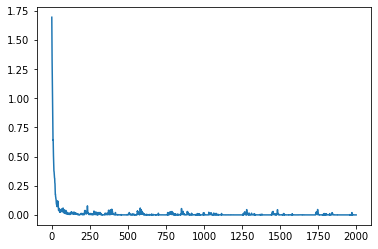

In [ ]:
pyplot.plot(history.history['loss'])
# pyplot.plot(history.history['val_loss'])
# pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
# pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

Get predicitons on test data

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

In [ ]:
y_test = np.argmax(y_test, axis=None)


0

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.74      0.70      0.72        20
           2       0.88      0.70      0.78        20
           3       0.74      0.85      0.79        20
           4       0.95      0.90      0.92        20
           5       0.91      1.00      0.95        20

    accuracy                           0.86       120
   macro avg       0.86      0.86      0.86       120
weighted avg       0.86      0.86      0.86       120



In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["nm","sitdown", "standup","walking","falling","getintobed"])

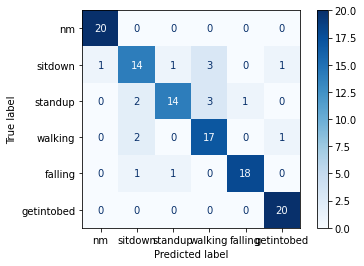

In [ ]:
disp.plot(cmap = "Blues")
plt.show()